In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel("../data/barnstable_analysis_data.xlsx", sheet_name="data")
df.set_index("date", inplace=True)
df.head()

,SPX,TB1M
date,,
1926-01-30,-0.001783,0.003061
1926-02-27,-0.033296,0.002612
1926-03-31,-0.057708,0.002601
1926-04-30,0.038522,0.002270
1926-05-28,0.013623,0.002691


In [3]:
df["TB1M"].ffill(inplace=True)      # Avoid missing period 
s = (df["SPX"] - df["TB1M"]).resample('1M').sum().rename('return')
s.describe()

count    1172.000000
mean        0.006876
std         0.054151
min        -0.288209
25%        -0.019886
50%         0.010033
75%         0.035896
max         0.413943
Name: return, dtype: float64

<Axes: title={'center': 'Historic VaR (Expanding from n=60)'}, xlabel='date'>

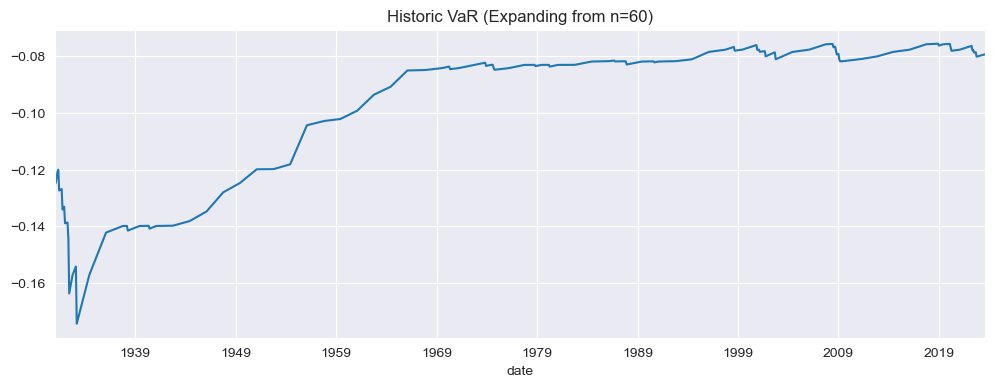

In [4]:
# 1. Historic VaR
var = s.shift(1).expanding(60).quantile(.05).dropna().rename('var')
var.plot(title="Historic VaR (Expanding from n=60)", figsize=(12, 4))

In [5]:
def count_worse_period(var_s: pd.Series) -> int:
    """
    Count #periods worse than VaR estimation
    
    :param:
        var_s (pd.Series): series for worse period calcultion
    """
    return (s.loc[var_s.index] < var_s).mean()
    
print("""
There are {:.4f}% periods with returns less than 5% VaR returns.
Downside is we only use 5% of the total sample to estimate VaR, i.e. we didn't fully utilize the statistical power in the sample set. 
""".format(count_worse_period(var)*100))


There are 3.1475% periods with returns less than 5% VaR returns.
Downside is we only use 5% of the total sample to estimate VaR, i.e. we didn't fully utilize the statistical power in the sample set. 


<Axes: title={'center': 'Historic Volatility (Expanding vs Rolling)'}, xlabel='date'>

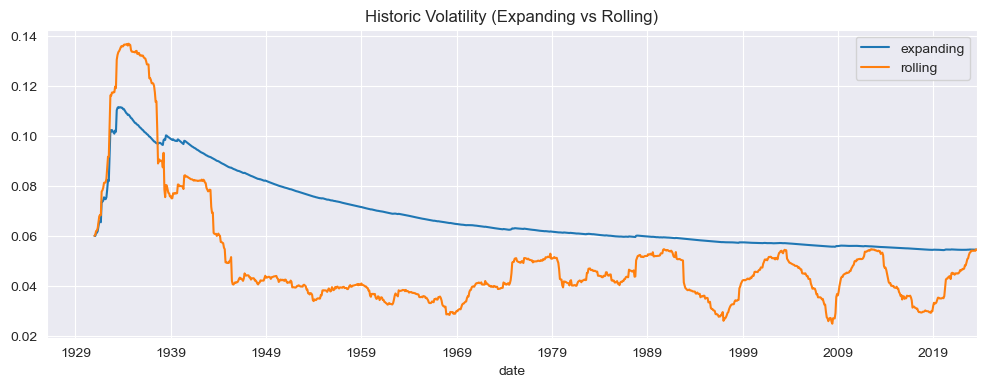

In [6]:
# 2. Volatility
vol = pd.concat([s.shift(1).pow(2).expanding(60).mean().pow(1/2).rename('expanding'),
                 s.shift(1).pow(2).rolling(60).mean().pow(1/2).rename('rolling')], axis=1)
vol.plot(title="Historic Volatility (Expanding vs Rolling)", figsize=(12, 4))

In [7]:
norm_var = vol * (-1.65)
norm_var_period = norm_var.dropna(how='any').apply(count_worse_period, axis=0).rename('worse period')
norm_var_period * 100

# % Period worse than VaR: 0.5 > empirical > rolling normal > expanding normal.

expanding    1.798561
rolling      4.946043
Name: worse period, dtype: float64

In [8]:
norm_var

,expanding,rolling
date,,
1926-01-31,NaN,NaN
1926-02-28,NaN,NaN
1926-03-31,NaN,NaN
1926-04-30,NaN,NaN
1926-05-31,NaN,NaN
...,...,...
2023-04-30,-0.090155,-0.089432
2023-05-31,-0.090118,-0.089465
2023-06-30,-0.090079,-0.089338


<Axes: title={'center': 'CVaR Comparison'}, xlabel='date'>

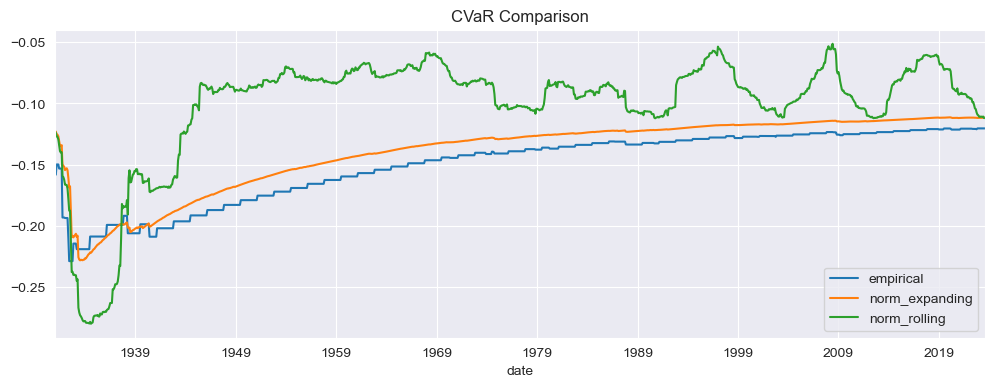

In [9]:
# 3. CVaR
from scipy.stats import norm
q = 0.05
zq = -1.65
pdf_zq = norm.pdf(zq)

mean = pd.concat([s.shift(1).expanding(60).mean().rename('mean_expanding'),
                  s.shift(1).rolling(60).mean().rename('mean_rolling')], axis=1)
mean_vol = pd.concat([mean, vol], axis=1)

cvar = pd.concat([
    s.shift(1).expanding(60).apply(lambda x: x.loc[x < x.quantile(.05)].mean()).rename('empirical'),
    (0 - pdf_zq / q * mean_vol['expanding']).rename('norm_expanding'),      # Use mean = 0
    (0 - pdf_zq / q * mean_vol['rolling']).rename('norm_rolling')
], axis=1).dropna(how='any')

cvar.plot(title="CVaR Comparison", figsize=(12, 4))

In [10]:
cvar_period = cvar.dropna(how='any').apply(count_worse_period, axis=0).rename('worse period')
cvar_period
# Using CVaR, all methods has worse period < 5%. Rolling normal still the one cloest

empirical         0.008094
norm_expanding    0.008993
norm_rolling      0.028777
Name: worse period, dtype: float64

In [11]:
# 4. Extra - EWMA
from itertools import pairwise
    
sigma = 0.97
ewma = s.pow(2).rename('r_2').to_frame()
ewma.loc[ewma.index[0], "ewma_2"] = 0.15 ** 2

for last_idx, new_idx in pairwise(ewma.index):
    ewma.loc[new_idx, "ewma_2"] = (sigma * ewma.loc[last_idx, "ewma_2"] + 
                                   (1 - sigma) * ewma.loc[last_idx, "r_2"])
    
ewma.loc[:, "ewma"] = ewma["ewma_2"] ** 0.5
ewma

,r_2,ewma_2,ewma
date,,,
1926-01-31,0.000023,0.022500,0.150000
1926-02-28,0.001289,0.021826,0.147735
1926-03-31,0.003637,0.021210,0.145635
1926-04-30,0.001314,0.020682,0.143814
1926-05-31,0.000120,0.020101,0.141779
...,...,...,...
2023-04-30,0.000133,0.002789,0.052815
2023-05-31,0.000001,0.002710,0.052055
2023-06-30,0.003925,0.002628,0.051269


In [12]:
# GARCH
from arch import arch_model

am = arch_model(s)
res = am.fit()
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 47894645.183721885
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1950.463412480511
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1950.4634158658437
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00293. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1950.46
Distribution:                  Normal   AIC:                          -3892.93
Method:            Maximum Likelihood   BIC:                          -3872.66
                                        No. Observations:                 1172
Date:                Sun, Oct 15 2023   Df Residuals:                     1171
Time:                        13:33:05   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.8695e-03  1.189e-03      6.621  3.567e-11 [5.540e-03,1.020e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.8639e-05  1.682e-05      3.486  4.908e-04 [2.567e-05,9.161e-05]
alpha[1]       0.1000  1.742e-02      5.741  9.388e-09   [6.586e-02,  0.134]
beta[1]        0.8800  1.349e-02     65.232      0.000     [  0.854,  0.906]
============================================================================

Covariance estimator: robust
"""

In [13]:
res.conditional_volatility

date
1926-01-31    0.044792
1926-02-28    0.042900
1926-03-31    0.043241
1926-04-30    0.046572
1926-05-31    0.045253
                ...   
2023-04-30    0.056853
2023-05-31    0.053892
2023-06-30    0.051176
2023-07-31    0.051608
2023-08-31    0.049397
Freq: M, Name: cond_vol, Length: 1172, dtype: float64

<Axes: title={'center': 'VaR Comparison'}, xlabel='date'>

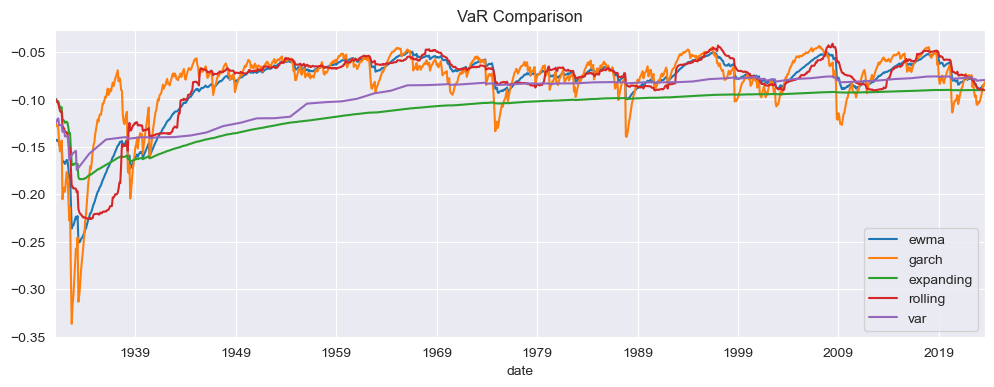

In [14]:
var_comp = pd.concat([
    ewma["ewma"],
    res.conditional_volatility.rename("garch"),
    vol,
], axis=1) * (-1.65)
var_comp = var_comp.join(var).dropna(how='any')
var_comp.plot(title="VaR Comparison", figsize=(12, 4))

In [15]:
all_var_period = var_comp.apply(count_worse_period, axis=0).rename('worse period')
all_var_period

ewma         0.043165
garch        0.044964
expanding    0.017986
rolling      0.049460
var          0.031475
Name: worse period, dtype: float64